# Project: Check bias of embeddings with WEAT score

## Rubric

### 1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.	
- 워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.

### 2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.	
- 타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.

### 3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.
- 전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.


In [1]:
import os
import numpy as np
from numpy import dot
import seaborn as sns
from numpy.linalg import norm
from konlpy.tag import Okt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

## STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [2]:
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [3]:
print(len(tokenized))

71156


In [4]:
tokenized[0]

['사운드', '엔지니어', '상우', '유지태', '분', '치매', '할머니', '백성희', '분']

## STEP 2. 추출된 결과로 embedding model 만들기

In [6]:
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  

#vector_size=100 -> latent vector dimension = 100
#window=5 -> context window size
#min_count -> min frequency limit
#sg=0 -> CBoW , sg=1 -> Skip-gram

In [40]:
model.wv.most_similar(positive=['항구'])

[('재개발', 0.9572354555130005),
 ('관광', 0.9501774311065674),
 ('관광객', 0.9420904517173767),
 ('외곽', 0.9415856599807739),
 ('아일랜드', 0.9371353387832642),
 ('교외', 0.9368118643760681),
 ('알래스카', 0.9367867708206177),
 ('중부', 0.9365115165710449),
 ('근교', 0.9360599517822266),
 ('해안', 0.9316615462303162)]

In [11]:
okt = Okt()

def read_token(file_name):
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [12]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [13]:
genre = [read_token(file_name) for file_name in genre_txt]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.
(21, 42191)


## STEP 3. target, attribute 단어 셋 만들기

In [15]:
m = [X[i].tocoo() for i in range(X.shape[0])]
w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
    
attributes = []

vocab_in_model = set(model.wv.index_to_key)
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15 and j < len(w[i])):
        word = vectorizer.get_feature_names_out()[w[i][j][0]]
        if word in vocab_in_model:
            attr.append(word)
            print(word, end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

In [16]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

In [17]:
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [18]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])  # term-document matrix가 생성됨

print(X.shape)

(2, 41082)


In [19]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [20]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 spart matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 spart matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [21]:
# 위에 출력한 것처럼 중복된 것이 많으므로 중복을 제외하고 상위n개의 단어를 추출
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [22]:
print(target_art)   # common general componets are skimmed from target_art 
print(target_gen)   # common artistic componets are skimmed from target_gen

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']
['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


## STEP 4. WEAT score 계산과 시각화

In [23]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B


def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [24]:
matrix = np.zeros((len(genre_name), len(genre_name)))

In [25]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [37]:
significant_pairs = []
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1 or matrix[i][j] < -1:
            significant_pairs.append((genre_name[i], genre_name[j], matrix[i][j]))


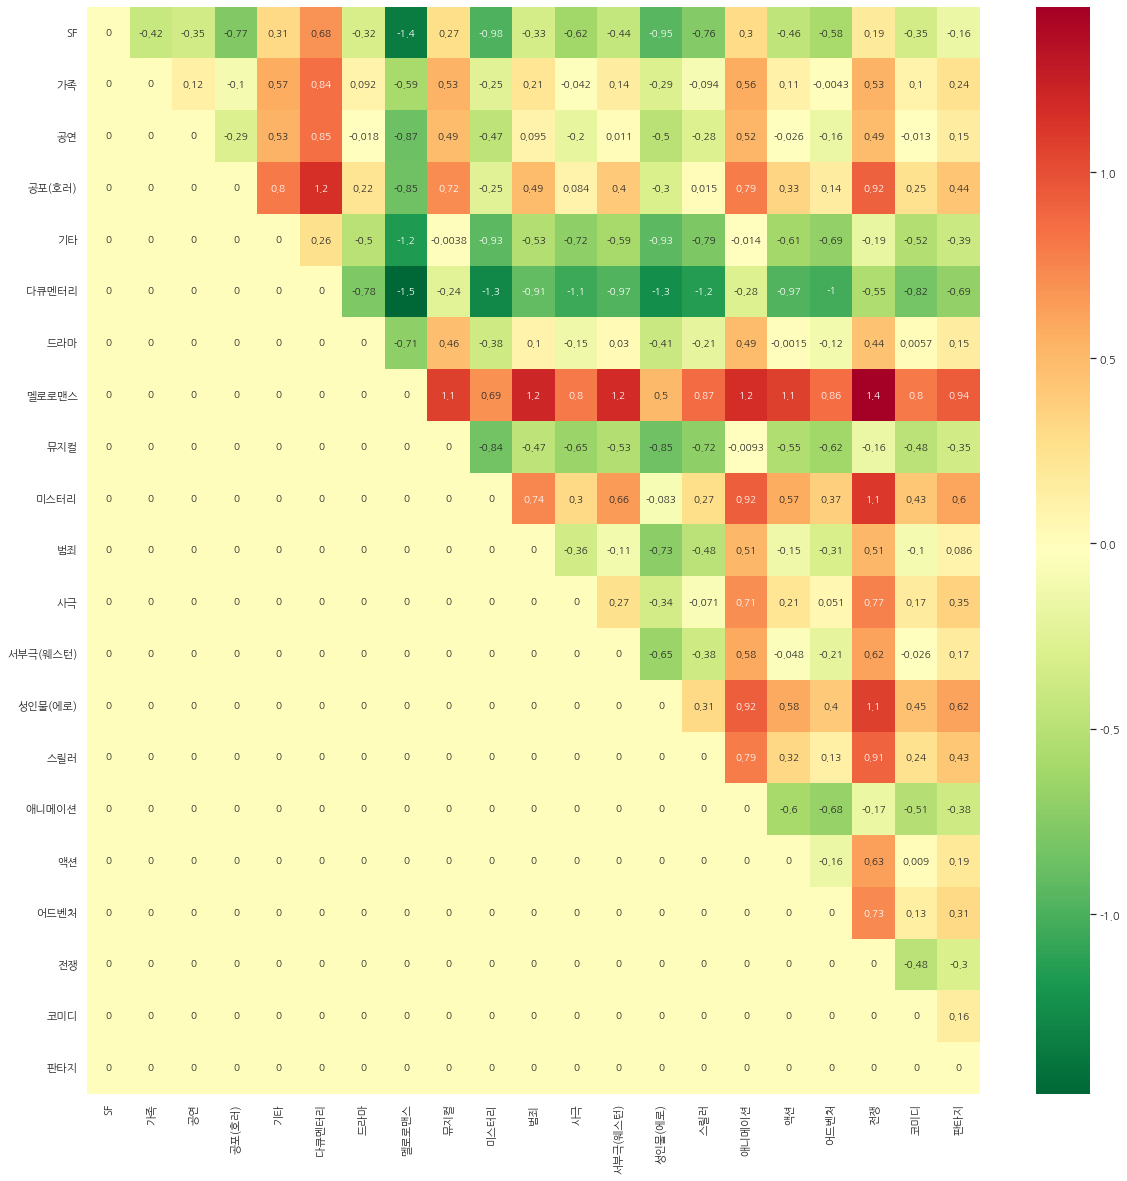

[('SF', '멜로로맨스', -1.3616122007369995),
 ('공포(호러)', '다큐멘터리', 1.1566640138626099),
 ('기타', '멜로로맨스', -1.1733657121658325),
 ('다큐멘터리', '멜로로맨스', -1.4853073358535767),
 ('다큐멘터리', '미스터리', -1.2793577909469604),
 ('다큐멘터리', '사극', -1.0525504350662231),
 ('다큐멘터리', '성인물(에로)', -1.253213882446289),
 ('다큐멘터리', '스릴러', -1.150633692741394),
 ('다큐멘터리', '어드벤처', -1.0308260917663574),
 ('멜로로맨스', '뮤지컬', 1.0710173845291138),
 ('멜로로맨스', '범죄', 1.2164194583892822),
 ('멜로로맨스', '서부극(웨스턴)', 1.1720585823059082),
 ('멜로로맨스', '애니메이션', 1.1711300611495972),
 ('멜로로맨스', '액션', 1.0748759508132935),
 ('멜로로맨스', '전쟁', 1.4462835788726807),
 ('미스터리', '전쟁', 1.1134634017944336),
 ('성인물(에로)', '전쟁', 1.0716356039047241)]

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt


# 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic' # 나눔고딕 사용
sns.set(font="NanumGothic") # seaborn에도 동일한 폰트 설정

# 그래프 그리기
plt.figure(figsize=(20,20))
ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, cmap='RdYlGn_r', annot_kws={"size": 10})
plt.show()


significant_pairs

## Compare attribute axis with Art(gen comps skimmed) - Gen(art comps skimmed) axis

### WEAT score interpretation

| Attribute1    | Attribute2     | WEAT Score | Interpretation (Closer to Art) | Interpretation (Closer to Gen) |
|:-------------:|:--------------:|:----------:|:----------------------:|:----------------------:|
| SF            | Melo-Romance   | -1.36      | SF                      | Melo-Romance           |
| Horror        | Documentary    | 1.16       | Documentary             | Horror                 |
| Others        | Melo-Romance   | -1.17      | Others                  | Melo-Romance           |
| Documentary   | Melo-Romance   | -1.49      | Documentary             | Melo-Romance           |
| Documentary   | Mystery        | -1.28      | Documentary             | Mystery                |
| Documentary   | Historical     | -1.05      | Documentary             | Historical             |
| Documentary   | Adult (Erotic) | -1.25      | Documentary             | Adult (Erotic)         |
| Documentary   | Thriller       | -1.15      | Documentary             | Thriller               |
| Documentary   | Adventure      | -1.03      | Documentary             | Adventure              |
| Melo-Romance  | Musical        | 1.07       | Musical                 | Melo-Romance           |
| Melo-Romance  | Crime          | 1.22       | Crime                   | Melo-Romance           |
| Melo-Romance  | Western        | 1.17       | Western                 | Melo-Romance           |
| Melo-Romance  | Animation      | 1.17       | Animation               | Melo-Romance           |
| Melo-Romance  | Action         | 1.07       | Action                  | Melo-Romance           |
| Melo-Romance  | War            | 1.45       | War                     | Melo-Romance           |
| Mystery       | War            | 1.11       | War                     | Mystery                |
| Adult (Erotic)| War            | 1.07       | War                     | Adult (Erotic)         |



